In [1]:
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np 

In [2]:
df = pd.read_table("In-class_network2.txt")

In [3]:
df.head()

,ID,IDs-of-acquaintances,sex,age,department,time-to-bed,Unnamed: 6
0,1,58,m,21,phys,after-0,NaN
1,2,"56,34,25",f,18,stat,after-0,NaN
2,4,"13,18,66,61,5,10",m,19,stat,after-0,NaN
3,5,"66,13,18",m,18,stat,after-0,NaN
4,6,"19,53,38",m,20,stat,after-0,NaN


In [4]:
G = nx.Graph()

In [5]:
for node , friends in df[["ID","IDs-of-acquaintances"]].values:
    if " " in friends: 
        G.add_node(node)
        continue
    friends = list(map(int,friends.split(",")))
    G.add_edges_from(list(zip([node]*len(friends),friends)))

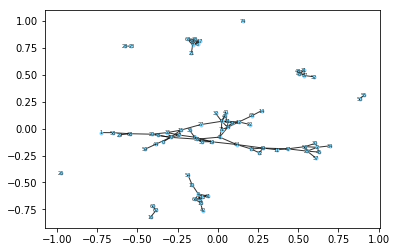

In [6]:
nx.draw_networkx(G,node_color="#7FDBFF",node_size=10,alpha=.8,font_size=5)

## 1. Number of Nodes : 75 
## 2. Number of edges ：109
## 3. Average Degree：2.907

In [7]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 75
Number of edges: 109
Average degree:   2.9067


## 4.average path length：1.7

In [8]:
total = 0
for i in nx.connected_components(G):
    len_g = len(G.subgraph(i).nodes)
    total += nx.average_shortest_path_length(G.subgraph(i))*(len_g*(len_g-1)/2)
total/75/75*2

1.7024000000000001

## 5.the size of the largest connected component nG : 45

In [9]:
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)

45